## **Course Name: 7PAM2021-0901-2025 - Machine Learning and Neural Networks**
### **Name: Muhammad Wasal Imtiaz**
### **Student ID: 24077342**

# **Tutorial: Denoising Autoencoders for Image Reconstruction**

Welcome to this practical tutorial for the **Machine Learning and Neural Networks** module. In this session, we will explore how neural networks can be used to learn robust representations of data by introducing and implementing **Denoising Autoencoders**.

Denoising Autoencoders are a powerful form of unsupervised learning, designed to reconstruct clean data from corrupted inputs. By intentionally adding noise to a dataset such as handwritten digits from the MNIST dataset, we can train a model that learns to ignore irrelevant variations and recover the underlying structure of the data.

In this tutorial, you will:

- Build a denoising autoencoder using the Keras deep learning framework.  
- Train the model on the MNIST dataset of handwritten digits.
- Add controlled noise to the input images to simulate real world data corruption.
- Compare original, noisy, and reconstructed outputs visually.
- Generate plots and reconstruction examples for inclusion in the accompanying PDF report.

By the end of this notebook, you will have a deeper understanding of how autoencoders extract meaningful, low dimensional representations and how denoising improves their ability to generalise beyond the input data.


## Imports & Reproducibility

In [1]:
# Adding Imports

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Set random seeds for reproducibility
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

## Load MNIST Dataset

In [2]:
# Loading the MNIST dataset
# We only need the images (x_train, x_test); labels are not used for autoencoders.

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

print("Training set shape:", x_train.shape)
print("Test set shape:", x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training set shape: (60000, 28, 28)
Test set shape: (10000, 28, 28)


## Preprocess: Normalise & Reshape

In [3]:
# Preprocessing: scale pixels to [0, 1] and add channel dimension

# Convert to float32 and scale from [0, 255] → [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add a channel dimension so the shape becomes (28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Training set reshaped:", x_train.shape)
print("Test set reshaped:", x_test.shape)


Training set reshaped: (60000, 28, 28, 1)
Test set reshaped: (10000, 28, 28, 1)


## Add Gaussian Noise

In [4]:
# Adding Gaussian noise to the images
# The model will see noisy inputs but is trained to reconstruct the clean images.

noise_factor = 0.2  # If this is too high, digits become unreadable and the task is impossible.

# Add Gaussian noise with mean 0 and standard deviation 1
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip to maintain valid pixel range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print("Noisy training set shape:", x_train_noisy.shape)
print("Noisy test set shape:", x_test_noisy.shape)


Noisy training set shape: (60000, 28, 28, 1)
Noisy test set shape: (10000, 28, 28, 1)


## Visualise Original vs Noisy

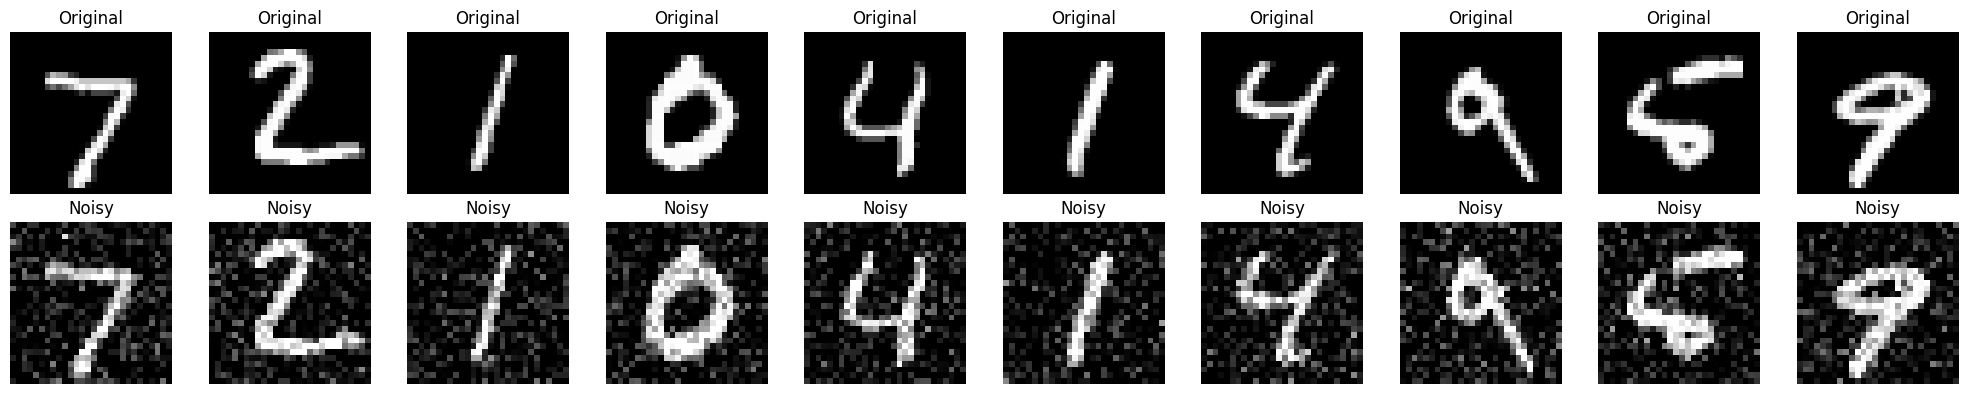

In [5]:
# Visualising a few original vs noisy examples

def show_noisy_examples(x_clean, x_noisy, n=10):
    """Display n original images (top row) and their noisy versions (bottom row)."""
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_clean[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_noisy[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Noisy")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_noisy_examples(x_test, x_test_noisy, n=10)



## Build the Denoising Autoencoder

In [6]:
# Building the convolutional denoising autoencoder

input_shape = (28, 28, 1)

# Input layer for 28x28 grayscale images
input_img = keras.Input(shape=input_shape, name="input_image")

# ----- Encoder -----
# First convolution + pooling: extract low-level features and downsample
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)   # -> 14x14

# Second convolution + pooling: deeper features, smaller spatial size
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)   # -> 7x7

# Latent representation (bottleneck)
latent = layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="latent")(x)

# ----- Decoder -----
# Mirror the encoder: upsample back to original resolution
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(latent)
x = layers.UpSampling2D((2, 2))(x)                   # -> 14x14

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)                   # -> 28x28

# Final reconstruction layer.
# Sigmoid ensures outputs lie in [0, 1], matching our normalised pixel range.
decoded = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same", name="output_image")(x)

# Full autoencoder model: maps noisy images to reconstructed clean images
autoencoder = keras.Model(input_img, decoded, name="denoising_autoencoder")

autoencoder.summary()


Model: "denoising_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Conv2D)                 │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_image (Conv2D)           │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,425 (435.25 KB)

 Trainable params: 111,425 (435.25 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

In [7]:
# Compiling the model
# Because the outputs are in [0, 1], binary cross-entropy works well for this reconstruction task.

autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["mse"]  # track mean squared error as an additional metric
)

## Train the Model with Early Stopping

In [8]:
# Training the denoising autoencoder

epochs = 50
batch_size = 128

# Early stopping stops training if validation loss does not improve for 5 epochs
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = autoencoder.fit(
    x_train_noisy, x_train,              # noisy input → clean target
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stop]
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 117s 245ms/step - loss: 0.1978 - mse: 0.0441 - val_loss: 0.0815 - val_mse: 0.0065
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 110s 235ms/step - loss: 0.0808 - mse: 0.0063 - val_loss: 0.0769 - val_mse: 0.0051
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 237ms/step - loss: 0.0769 - mse: 0.0050 - val_loss: 0.0751 - val_mse: 0.0045
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 145s 244ms/step - loss: 0.0752 - mse: 0.0045 - val_loss: 0.0740 - val_mse: 0.0042
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 138s 234ms/step - loss: 0.0741 - mse: 0.0042 - val_loss: 0.0731 - val_mse: 0.0039
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 231ms/step - loss: 0.0734 - mse: 0.0039 - val_loss: 0.0724 - val_mse: 0.0037
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - loss: 0.0728 - mse: 0.0038 - val_loss: 0.0719 - val_mse: 0.0036
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 109s 232ms/step - loss: 0.0723 - mse: 0.0036 - val_loss: 0.0716 - val_mse: 0.0035
Epoch 9/50
469/469 ━━━━━

## Plot Training & Validation Loss

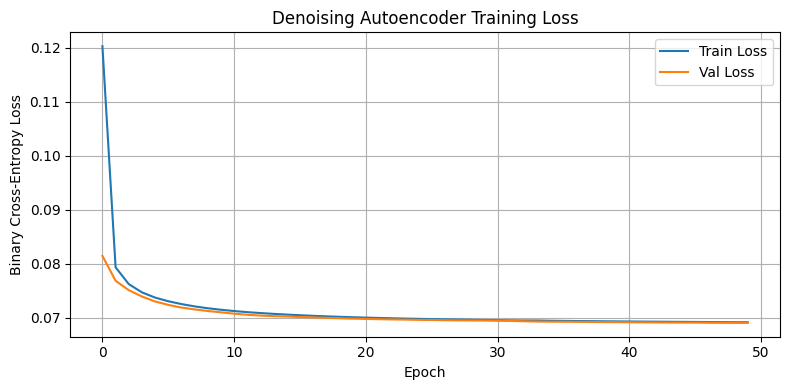

In [9]:
# Plotting the training and validation loss curves

def plot_history(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Binary Cross-Entropy Loss")
    plt.title("Denoising Autoencoder Training Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history)

## Generate Denoised Reconstructions

In [10]:
# Using the trained model to reconstruct (denoise) the test images

decoded_imgs = autoencoder.predict(x_test_noisy)

print("Decoded images shape:", decoded_imgs.shape)


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Decoded images shape: (10000, 28, 28, 1)


## Visualise Original vs Noisy vs Denoised

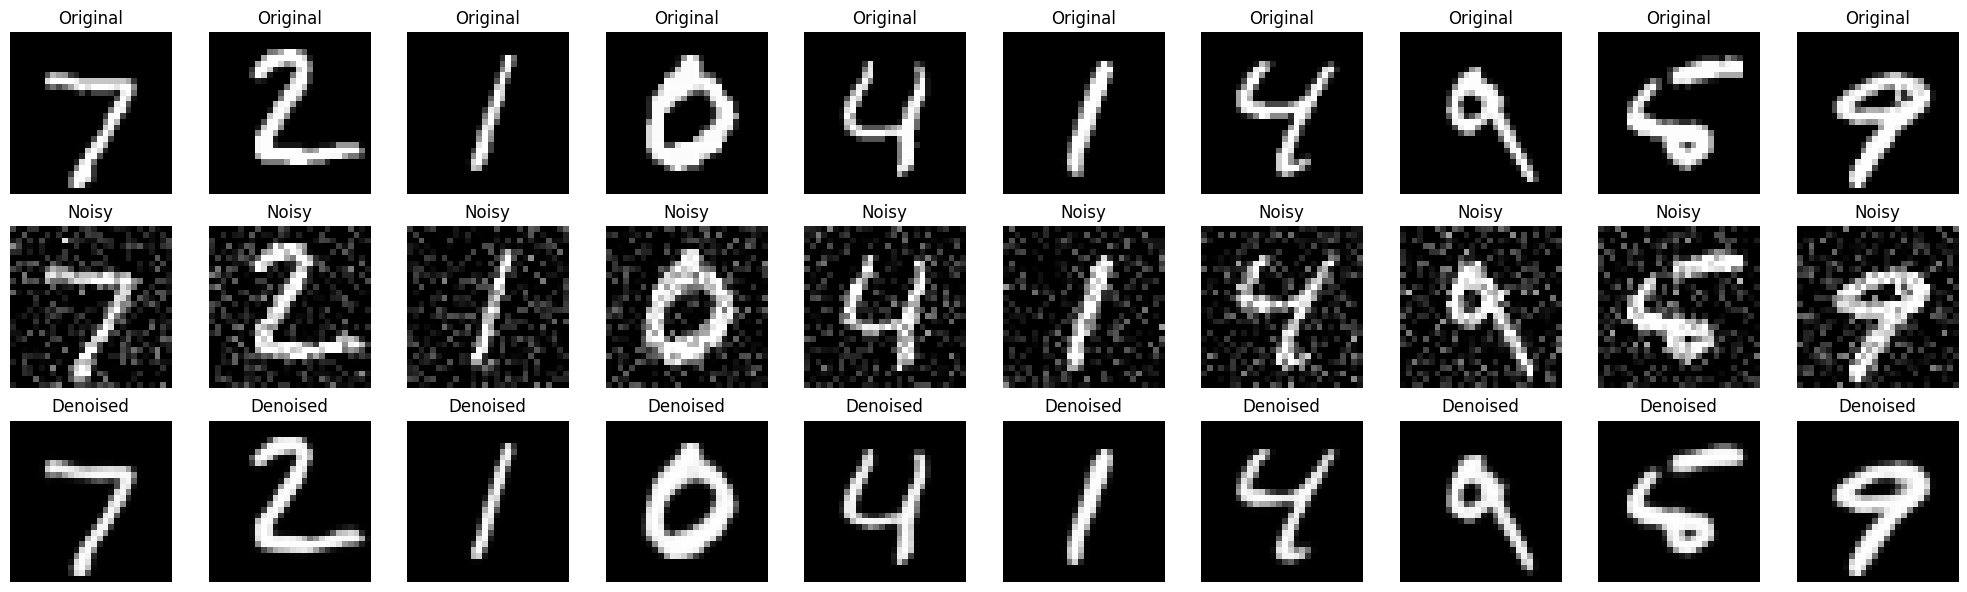

In [11]:
# Visual comparison: Original vs Noisy vs Denoised

def show_denoising_results(x_clean, x_noisy, x_decoded, n=10):
    """
    Display n samples in three rows:
    - Top: original clean images
    - Middle: noisy corrupted images
    - Bottom: denoised reconstructions from the autoencoder
    """
    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_clean[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Original")
        plt.axis("off")

        # Noisy
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(x_noisy[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Noisy")
        plt.axis("off")

        # Denoised
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(x_decoded[i].squeeze(), cmap="gray", vmin=0, vmax=1)
        plt.title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_denoising_results(x_test, x_test_noisy, decoded_imgs, n=10)



## Latent Space & Saving Outputs

In [12]:
# Inspect latent representations and save outputs

# Build a separate encoder model to access the latent space
encoder = keras.Model(autoencoder.input, autoencoder.get_layer("latent").output, name="encoder_model")
encoder.summary()

# Get latent representations for a subset of test images
latent_repr = encoder.predict(x_test[:1000])
print("Latent representation shape:", latent_repr.shape)

# Save arrays for later use
np.save("x_test_original.npy", x_test)
np.save("x_test_noisy.npy", x_test_noisy)
np.save("x_test_denoised.npy", decoded_imgs)



Model: "encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent (Conv2D)                 │ (None, 7, 7, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,744 (217.75 KB)

 Trainable params: 55,744 (217.75 KB)

 Non-trainable params: 0 (0.00 B)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Latent representation shape: (1000, 7, 7, 64)


# Latent Feature Visualisation

Latent representation shape: (1000, 7, 7, 64)




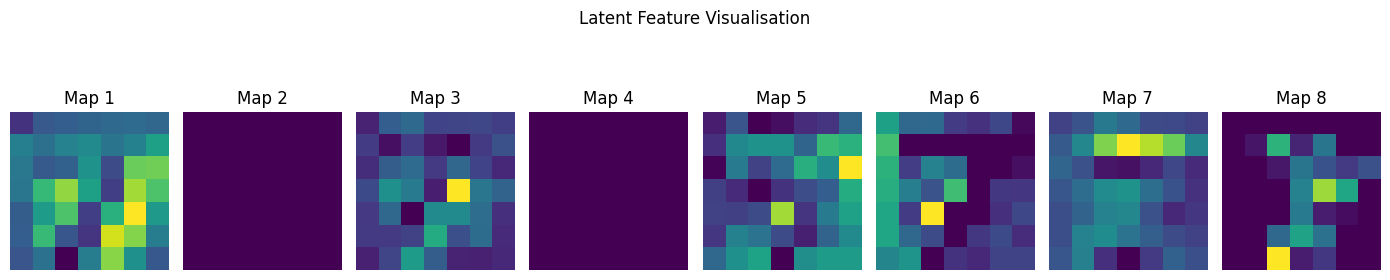

In [22]:
# Visualising latent feature maps for one test image

print("Latent representation shape:", latent_repr.shape)

sample_index = 0      # which test image to inspect
num_feature_maps = 8  # how many channels to display

feature_maps = latent_repr[sample_index]  # shape: (7, 7, 64)

plt.figure(figsize=(14, 3))
for i in range(num_feature_maps):
    ax = plt.subplot(1, num_feature_maps, i + 1)
    plt.imshow(feature_maps[:, :, i], cmap="viridis")
    plt.title(f"Map {i+1}")
    plt.axis("off")
print('\n')
plt.suptitle("Latent Feature Visualisation", y=1.05, fontsize=12)
plt.tight_layout()
plt.show()
print('\n')